# Supplementary Information: Holmes *et al.* 2017

# 3. An unpooled model

In [1]:
%pylab inline

import numpy as np
import pandas as pd
import pystan
import scipy
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

sns.set_context('notebook')

Populating the interactive namespace from numpy and matplotlib


/Users/lpritc/Development/GitHub/Supplementary_Info/SI_Holmes_etal_2016/venv-SI_Holmes_2016/lib/python3.5/site-packages/Cython/Distutils/old_build_ext.py:30: UserWarning: Cython.Distutils.old_build_ext does not properly handle dependencies and is deprecated.
  "Cython.Distutils.old_build_ext does not properly handle dependencies "


## Building the model

With this unpooled model, we treat each probe (across both conditions) as if its measurements before and after the experiment were drawn from a distribution specific to that probe, where that the output value is (still) some linear function of the input value, mediated by the experiment.

We construct the following model of the experiment:

$$y_i = \alpha + \beta_$j[i]$ x_i + \epsilon_i$$

* $y_i$: measured log(intensity) output on the array for probe $i$ (specific to each replicate)
* $x_i$: measured log(intensity) input on the array for probe $i$ (specific to each replicate)
* $\alpha$: a representative log(intensity) level for the input array
* $\beta_{j[i]}$: the effect of the experiment on the measured log(intensity) for probe $i$ (combined across all replicates, where $j[i]$ is the probe identity, rather than the specific probe for a single replicate)
* $\epsilon_i$: error in the model prediction for probe $i$

### Stan model construction and fit

We need to define `data`, `parameters` and our `model` for `Stan`.

In the `data` block, we have:

* `N`: `int`, the number of data points)
* `J`: `int`, the number of unique probe IDs (`J` < `N`)
* `probe`: `int[N]`, an index list of probe identities - one index representing six probe measurements (i.e. three control, three treatment) - there are `J` probes
* `x`: `vector[N]`, the input log(intensity) values
* `y`: `vector[N]`, the output log(intensity) values

In the `parameter` block, we have:

* `a`: `real`, representative input log(intensity)
* `b`: `real vector[J]`, effect on log(intensity) of passing through the experiment, specific to a probe ID
* `sigma`: `real<lower=0>`, the error in the prediction

We also define a `transformed parameter`:

* `y_hat[i] <- b[probe[i]] * x[i] + a`: the linear relationship describing $\hat{y}$, our estimate of experimental output intensity, which is subject to variance `sigma`.

We define the model as $y \sim N(\hat{y}, \sigma^2)$.

We map Python variables to `stan` variables, so we need to load our cleaned, normalised dataset, and create an index for each probe ID.

In [2]:
# load clean, normalised data
data = pd.read_csv("output/normalised_array_data.tab", sep="\t")

# create indices and values for probes
probe_ids = data['probe'].unique()
nprobes = len(probe_ids)
probe_lookup = dict(zip(probe_ids, range(nprobes)))

# add data column with probe index from probe_lookup
data['probe_index'] = data['probe'].replace(probe_lookup).values

In [3]:
# define unpooled stan model
unpooled_model = """
data {
  int<lower=0> N;
  int<lower=0> J;
  int<lower=1, upper=J> probe[N];
  vector[N] x;
  vector[N] y;
}
parameters {
  real a;
  vector[J] b;
  real<lower=0> sigma;
}
transformed parameters{
  vector[N] y_hat;

  for (i in 1:N)
    y_hat[i] = a + b[probe[i]] * x[i];
}
model {
  y ~ normal(y_hat, sigma);
}
"""

In [4]:
# relate python variables to stan variables
unpooled_data_dict = {'N': len(data),
                      'J': nprobes,
                      'probe': data['probe_index'] + 1,
                      'x': data['input'],
                      'y': data['output']}

In [5]:
# run stan fit
unpooled_fit = pystan.stan(model_code=unpooled_model,
                           data=unpooled_data_dict,
                           iter=1000, chains=2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bead0bcd635d99cdf2820a22fffd2b0e NOW.


## Inspecting the fit

We cannot inspect the fitted parameter estimates quite so straightforwardly, as there are now approximately 11000 parameters describing the slope for individual probe IDs, $\beta_j[i]$. We can, however, get an estimate of the range of values those slopes and look at the potential for outliers - specific probe IDs that look as though they may deviate quite far from the mean of all estimates.

In [6]:
# Get fits by probe ID
unpooled_estimates = pd.Series(unpooled_fit['b'].mean(0), index=probe_ids)
unpooled_se = pd.Series(unpooled_fit['b'].std(0), index=probe_ids)

In [7]:
# Inspect the estimates
unpooled_estimates.head()

A_07_P010355   -2.787029
A_07_P039196   -1.443608
A_07_P039195   -1.138020
A_07_P039186    0.696466
A_07_P039181   -4.021668
dtype: float64

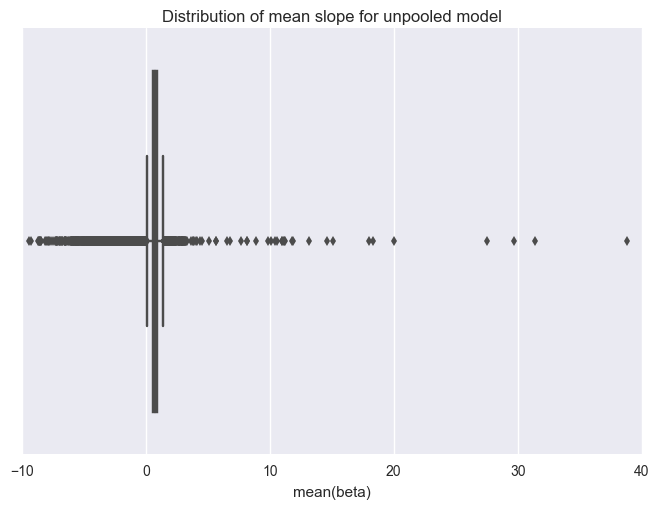

In [8]:
# Plot distribution
g = sns.boxplot(unpooled_estimates)
g.set_title("Distribution of mean slope for unpooled model")
g.set_xlabel("mean(beta)");

From the boxplot we can see that the distribution of mean inferred values of beta (by probe ID) is very tight, and close to zero. There are quite a few negative values, but the ones we might be most interested in are large and positive (indicating a tendency to give a stronger signal post-experiment than pre-experiment). We can look at these more closely.

In [9]:
# Extract strongly positive results
strong_positive = unpooled_estimates.loc[unpooled_estimates > 5]
strong_positive_se = unpooled_se.loc[unpooled_se.index.isin(strong_positive.index)]

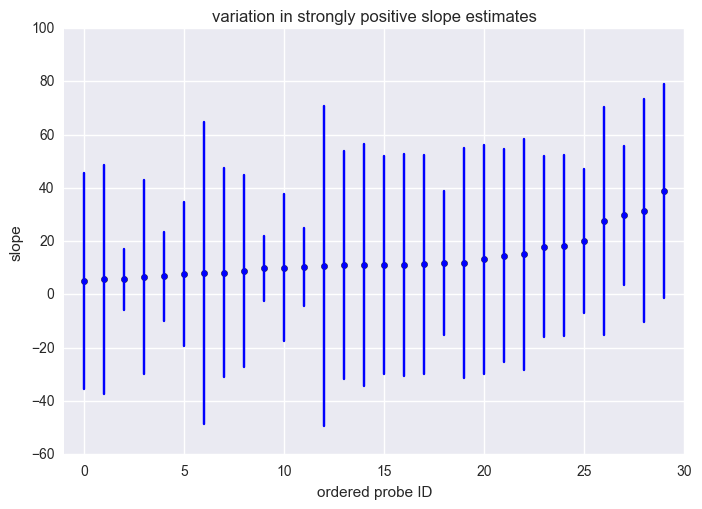

In [10]:
# Plot strongly positive results
order = strong_positive.sort_values().index
plt.scatter(range(len(strong_positive)), strong_positive[order])
for idx, mn, se in zip(range(len(strong_positive)),
                       strong_positive[order],
                       strong_positive_se[order]):
    plt.plot([idx, idx], [mn - se, mn + se], 'b-')
plt.xlabel("ordered probe ID")
plt.ylabel('slope')
plt.xlim(-1, 30)
plt.title("variation in strongly positive slope estimates");

From this plot, we can see that although there may be several strongly positive effects due to conducting the experiment, the variation is very large, and only one of the estimates has a standard error that does not include zero.

At this point, we are still not capturing information important for our central question:

* we are combining experiments with and without passage
* we are assuming a pooled intercept (the same base level of expression for all probes)
* whether probes that hybridise to Sakai have a different signal
* we are not incorporating any pertinent biological information (e.g. hierarchy of operons/regulons)

and it is possible that by extending our model we can reduce the variability we see in these estimates